# Multivariate Timeseries Forecasting of Gold Prices in lieu of COVID-19

For retail investors it is common to invest in Gold during times of economic and geopolitical turmoil as suggested by [Credit Suisse](https://www.credit-suisse.com/ch/en/articles/private-banking/krisensicher-investieren-in-gold-anlegen-und-marktrisiken-abfedern-201912.html). COVID-19 was one such event and I wanted to test the possibility of using the COVID-19 cases and the associated vaccination efforts to predict gold prices, thus ideally [MAPE should be less than 5%](https://www.vexpower.com/brief/mean-absolute-percentage-error#:~:text=What%20is%20a%20good%20mean,than%2025%25%20very%20low%20accuracy.).

## Hypothesis
Null Hypothesis: The MAPE for the predictions is less than or equal 5%

Alternate Hypothesis: The MAPE for the predictions is greater than 5%

## Data

**COVID-19:** For the COVID-19 the data was provided by [Our World in Data](https://github.com/owid/covid-19-data) from January 2020 to January 2022 and considered weekly  global new cases and new vaccinations data as the covariates.

**Gold Prices:** For the gold price data I used the data provided by [World Gold Council](https://www.gold.org/goldhub/data/gold-prices) and tracked the weekly gold prices from February 2012 to January 2022.

## Notes

I utilized Optuna for dynamic hyperparameter optimization instead of Gridsearch to have better performance.

## Author
**Name:** Vedang Naik

**Date:** 22/02/2024

In [1]:
import pandas as pd

# Set the display format for floats
pd.set_option('display.float_format', lambda x: '%.2f' % x)

# Load the dataset
df = pd.read_csv('/kaggle/input/d/vedangnaik/gold-price-and-covid/owid-covid-data.csv')

# Convert the date column to datetime
df['date'] = pd.to_datetime(df['date'])
df = df[df['date'] <= '2022-02-01']

# Group by date and sum the new_cases and new_vaccinations for all locations for each date
df_new = df.groupby('date').agg({'new_cases': 'sum', 'new_vaccinations': 'sum'}).reset_index()

df_new['total_cases'] = df_new['new_cases'].cumsum()
df_new['total_vaccinations'] = df_new['new_vaccinations'].cumsum()

print(df_new)

          date    new_cases  new_vaccinations   total_cases  \
0   2020-01-01         0.00              0.00          0.00   
1   2020-01-02         0.00              0.00          0.00   
2   2020-01-03         0.00              0.00          0.00   
3   2020-01-04         0.00              0.00          0.00   
4   2020-01-05         9.00              0.00          9.00   
..         ...          ...               ...           ...   
758 2022-01-28         0.00      106444140.00 1484405739.00   
759 2022-01-29         0.00       81322984.00 1484405739.00   
760 2022-01-30 102486879.00       73116888.00 1586892618.00   
761 2022-01-31         0.00       82751893.00 1586892618.00   
762 2022-02-01         0.00       80399575.00 1586892618.00   

     total_vaccinations  
0                  0.00  
1                  0.00  
2                  0.00  
3                  0.00  
4                  0.00  
..                  ...  
758      39791477051.00  
759      39872800035.00  
760      

In [2]:
xls = pd.ExcelFile('/kaggle/input/d/vedangnaik/gold-price-and-covid/Gold_Prices.xlsx')

# Load a specific sheet of the Excel file by name
df_price = pd.read_excel(xls, 'Weekly_EoP')
df_price

,date,USD,EUR,JPY,GBP,CAD,CHF,INR,CNY,TRY,SAR,IDR,AED,THB,VND,EGP,KRW,RUB,ZAR,AUD
0,1978-12-29,226.00,137.06,NaN,110.70,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1979-01-05,225.50,138.35,44582.47,111.63,268.39,373.72,1843.57,NaN,NaN,756.42,142069.10,875.38,4580.57,NaN,NaN,110510.44,NaN,196.40,197.94
2,1979-01-12,217.60,134.08,42837.13,109.02,257.19,364.62,1782.62,NaN,NaN,727.06,137371.81,842.09,4429.12,NaN,NaN,106856.59,NaN,187.08,189.80
3,1979-01-19,230.55,141.14,46908.77,115.07,280.94,396.08,1940.75,NaN,NaN,782.11,147159.35,899.07,4764.43,NaN,NaN,116335.53,NaN,206.50,207.64
4,1979-01-26,235.45,144.64,46801.30,118.02,279.57,394.61,1929.26,NaN,NaN,782.17,146687.14,899.62,4752.94,NaN,NaN,115646.54,NaN,204.26,205.97
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2347,2023-12-22,2041.70,1858.46,290472.66,1612.21,2717.91,1752.19,169918.44,14573.25,59536.38,7659.03,31627974.70,7498.35,70983.78,49674561.00,63095.47,2651290.37,187740.44,37577.49,3011.36
2348,2023-12-29,2078.40,1876.83,293511.65,1631.53,2746.81,1747.73,172873.21,14775.35,61211.17,7794.00,32094652.80,7633.55,71050.10,50430297.60,64277.01,2677124.69,184458.00,38464.12,3035.93
2349,2024-01-05,2056.35,1878.63,297656.66,1616.12,2743.58,1747.69,170942.11,14696.73,61365.60,7711.93,31939228.20,7552.36,71429.37,50080347.90,63331.47,2701118.54,186998.92,38421.05,3062.78
2350,2024-01-12,2055.65,1877.31,297987.02,1613.54,2755.19,1754.29,170304.64,14735.93,61873.01,7709.92,31967413.15,7550.20,71884.02,50365480.65,63516.91,2698492.87,181692.74,38358.22,3074.10


In [3]:
df_price = df_price[df_price['date'] >= '2012-02' ]
df_price = df_price[df_price['date'] <= '2022-02-01']
df_price = df_price.loc[:, ['date', 'USD', 'CHF']]
df_price['date'] = pd.to_datetime(df_price['date'])
df_price


,date,USD,CHF
1727,2012-02-03,1734.00,1593.37
1728,2012-02-10,1711.50,1568.59
1729,2012-02-17,1723.00,1582.75
1730,2012-02-24,1777.50,1589.80
1731,2012-03-02,1707.00,1559.34
...,...,...,...
2244,2021-12-31,1805.85,1651.27
2245,2022-01-07,1792.60,1647.04
2246,2022-01-14,1822.95,1666.36
2247,2022-01-21,1837.60,1675.16


In [4]:
merged_df = df_price.merge(df_new, left_on='date', right_on='date', how='left')

merged_df['new_cases'] = merged_df['total_cases'] - merged_df['total_cases'].shift(1)
merged_df['new_vaccinations'] = merged_df['total_vaccinations'] - merged_df['total_vaccinations'].shift(1)
# For the first row, new_cases should be same as total_cases
merged_df.loc[0, 'new_cases'] = merged_df.loc[0, 'total_cases']
merged_df.loc[0, 'new_vaccinations'] = merged_df.loc[0, 'total_vaccinations']
# merged_df.set_index('date', inplace=True)
print(merged_df)

          date     USD     CHF    new_cases  new_vaccinations   total_cases  \
0   2012-02-03 1734.00 1593.37          NaN               NaN           NaN   
1   2012-02-10 1711.50 1568.59          NaN               NaN           NaN   
2   2012-02-17 1723.00 1582.75          NaN               NaN           NaN   
3   2012-02-24 1777.50 1589.80          NaN               NaN           NaN   
4   2012-03-02 1707.00 1559.34          NaN               NaN           NaN   
..         ...     ...     ...          ...               ...           ...   
517 2021-12-31 1805.85 1651.27  26517479.00      967612873.00 1174983588.00   
518 2022-01-07 1792.60 1647.04  45814088.00      868572779.00 1220797676.00   
519 2022-01-14 1822.95 1666.36  72026916.00      884187183.00 1292824592.00   
520 2022-01-21 1837.60 1675.16  89244843.00      854736437.00 1382069435.00   
521 2022-01-28 1788.15 1665.13 102336304.00      696499473.00 1484405739.00   

     total_vaccinations  
0                   NaN  

In [5]:
!pip install darts

  Obtaining dependency information for darts from https://files.pythonhosted.org/packages/89/29/d5d086caa378240deb5d5e90982c772a8c4367e8688fb80754598ee35d14/darts-0.27.2-py3-none-any.whl.metadata
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 48.3/48.3 kB 775.0 kB/s eta 0:00:00a 0:00:01
  Obtaining dependency information for nfoursid>=1.0.0 from https://files.pythonhosted.org/packages/0a/92/dda081df8d207b72e419ef5dbd6a861041ceabdc609557249f334555a619/nfoursid-1.0.1-py3-none-any.whl.metadata
  Obtaining dependency information for pmdarima>=1.8.0 from https://files.pythonhosted.org/packages/ec/2b/e7d18360d56396b62781ba4616527af49244d4bed51f0780646fa3953cc8/pmdarima-2.0.4-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.manylinux_2_28_x86_64.whl.metadata
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 160.5/160.5 kB 2.6 MB/s eta 0:00:00a 0:00:01
  Preparing metadata (setup.py) ... done
  Obtaining dependency information for statsforecast>=1.4 from https://files.pythonhosted.org/packages/

In [6]:
from darts import TimeSeries
from darts.models import BlockRNNModel, TCNModel, TransformerModel
from darts.metrics import mape
from darts.utils.statistics import check_seasonality, plot_acf
from darts.dataprocessing.transformers import Scaler
from sklearn.preprocessing import MaxAbsScaler
import pandas as pd
import numpy as np


/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
/opt/conda/lib/python3.10/site-packages/dask/dataframe/_pyarrow_compat.py:23: UserWarning: You are using pyarrow version 11.0.0 which is known to be insecure. See https://www.cve.org/CVERecord?id=CVE-2023-47248 for further details. Please upgrade to pyarrow>=14.0.1 or install pyarrow-hotfix to patch your current version.
  warnings.warn(


In [7]:
merged_df.fillna(0, inplace=True)
# Create a time series for each variable
# Create a time series for gold prices
series_usd = TimeSeries.from_dataframe(merged_df, 'date', 'USD')

# Create a time series for the covariates
covariates = TimeSeries.from_dataframe(merged_df, 'date', ['new_cases', 'new_vaccinations'])

scaler = Scaler(MaxAbsScaler())
series_usd_scaled = scaler.fit_transform(series_usd).astype(np.float32)
cov_scaler = Scaler(MaxAbsScaler())
covariates_scaled = cov_scaler.fit_transform(covariates).astype(np.float32)

In [8]:
series= series_usd_scaled.drop_after(pd.Timestamp('2021-07-01'))
validate = series_usd_scaled.drop_before(pd.Timestamp('2021-07-01'))
past_covariates = covariates_scaled.drop_after(pd.Timestamp('2021-07-01'))
future_covariates = covariates_scaled.drop_before(pd.Timestamp('2021-07-01'))

In [9]:
print(validate.time_index)

DatetimeIndex(['2021-07-02', '2021-07-09', '2021-07-16', '2021-07-23',
               '2021-07-30', '2021-08-06', '2021-08-13', '2021-08-20',
               '2021-08-27', '2021-09-03', '2021-09-10', '2021-09-17',
               '2021-09-24', '2021-10-01', '2021-10-08', '2021-10-15',
               '2021-10-22', '2021-10-29', '2021-11-05', '2021-11-12',
               '2021-11-19', '2021-11-26', '2021-12-03', '2021-12-10',
               '2021-12-17', '2021-12-24', '2021-12-31', '2022-01-07',
               '2022-01-14', '2022-01-21', '2022-01-28'],
              dtype='datetime64[ns]', name='date', freq='W-FRI')


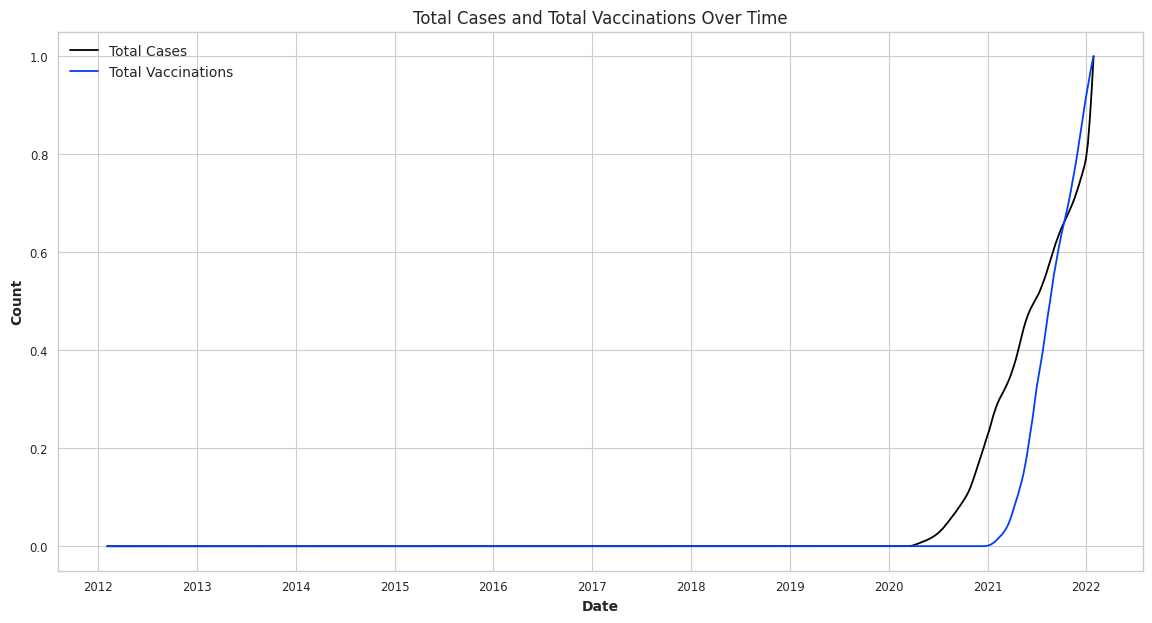

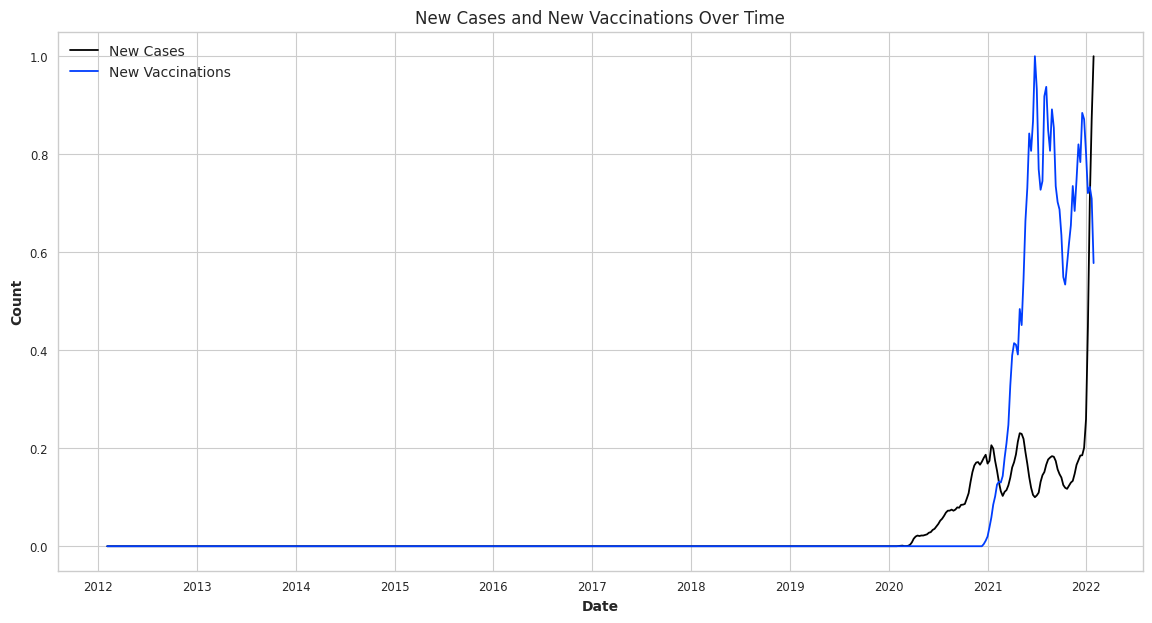

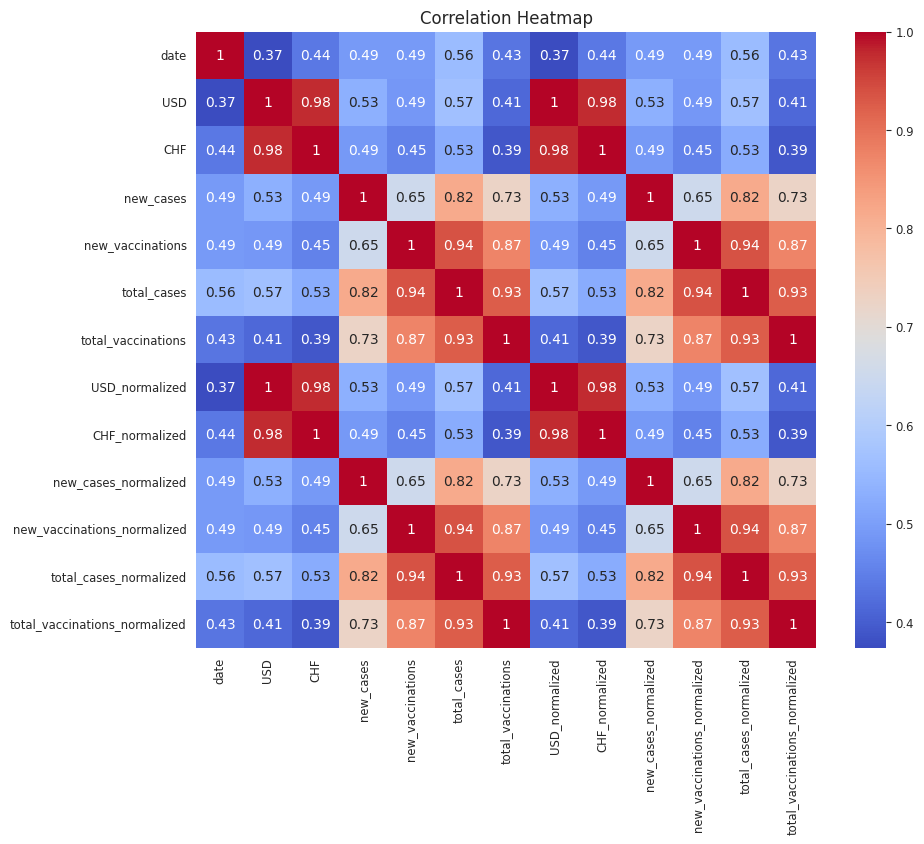

In [46]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler

# Set the style of seaborn
sns.set_style('whitegrid')

# Line plot of total_cases and total_vaccinations over time
plt.figure(figsize=(14, 7))
scaler = MinMaxScaler()
merged_df['total_cases_normalized'] = scaler.fit_transform(merged_df[['total_cases']])
scaler = MinMaxScaler()
merged_df['total_vaccinations_normalized'] = scaler.fit_transform(merged_df[['total_vaccinations']])
plt.plot(merged_df['date'], merged_df['total_cases_normalized'], label='Total Cases')
plt.plot(merged_df['date'], merged_df['total_vaccinations_normalized'], label='Total Vaccinations')
plt.title('Total Cases and Total Vaccinations Over Time')
plt.xlabel('Date')
plt.ylabel('Count')
plt.legend()
plt.show()

# Line plot of new_cases and new_vaccinations over time
plt.figure(figsize=(14, 7))
scaler = MinMaxScaler()
merged_df['new_cases_normalized'] = scaler.fit_transform(merged_df[['new_cases']])
plt.plot(merged_df['date'], merged_df['new_cases_normalized'], label='New Cases')
scaler = MinMaxScaler()
merged_df['new_vaccinations_normalized'] = scaler.fit_transform(merged_df[['new_vaccinations']])
plt.plot(merged_df['date'], merged_df['new_vaccinations_normalized'], label='New Vaccinations')
plt.title('New Cases and New Vaccinations Over Time')
plt.xlabel('Date')
plt.ylabel('Count')
plt.legend()
plt.show()

# Correlation heatmap of all numeric variables
plt.figure(figsize=(10, 8))
sns.heatmap(merged_df.corr(), annot=True, cmap='coolwarm')
plt.title('Correlation Heatmap')
plt.show()

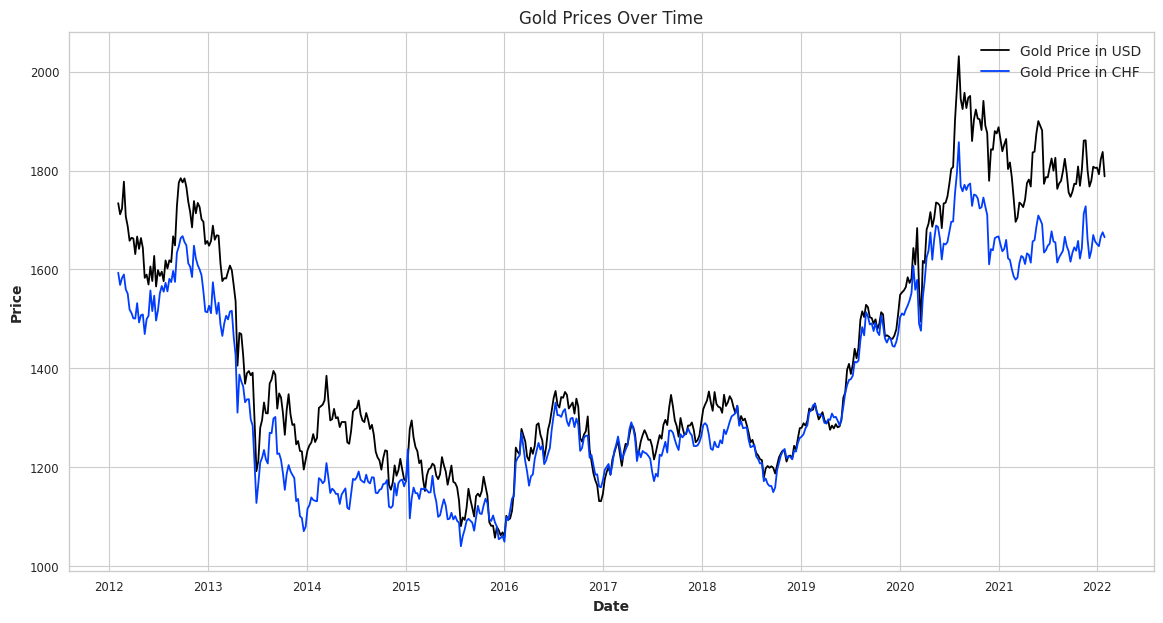

In [43]:
plt.figure(figsize=(14, 7))
plt.plot(merged_df['date'], merged_df['USD'], label='Gold Price in USD')
plt.plot(merged_df['date'], merged_df['CHF'], label='Gold Price in CHF')
plt.title('Gold Prices Over Time')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.show()

<Figure size 1400x700 with 0 Axes>

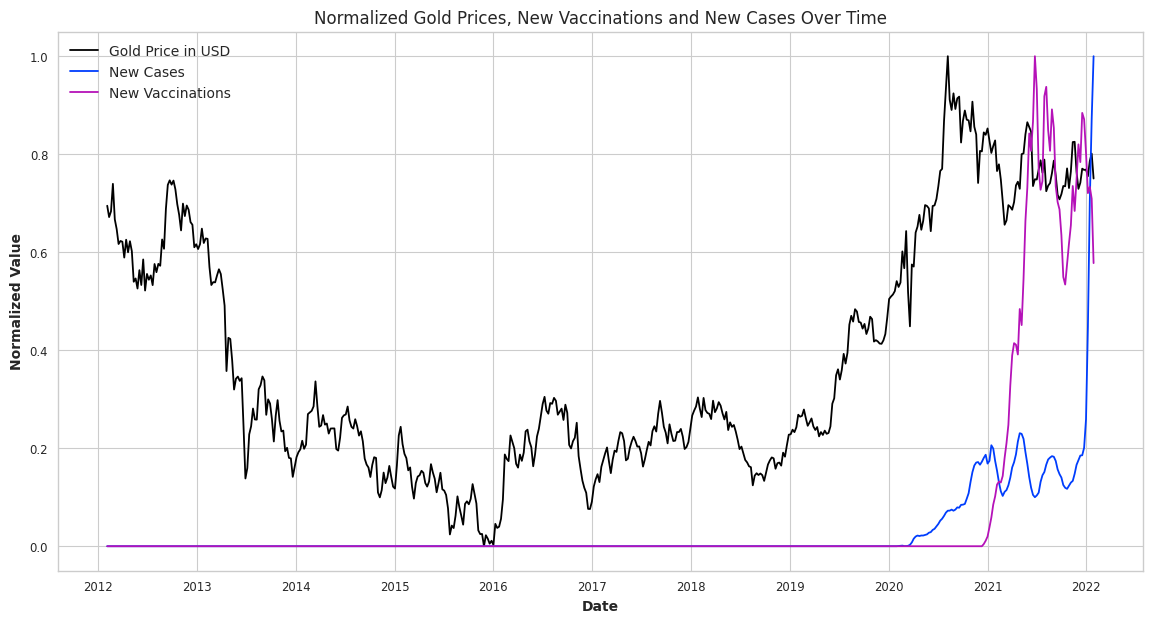

In [47]:
from sklearn.preprocessing import MinMaxScaler
plt.figure(figsize=(14, 7))
# plt.plot(merged_df['date'], merged_df['USD'], label='Gold Price in USD')
# plt.plot(merged_df['date'], merged_df['new_cases'], label='New Cases')
# Create a MinMaxScaler object
scaler = MinMaxScaler()

# Normalize the 'USD' and 'new_cases' columns
merged_df['USD_normalized'] = scaler.fit_transform(merged_df[['USD']])
scaler = MinMaxScaler()
merged_df['CHF_normalized'] = scaler.fit_transform(merged_df[['CHF']])

# Plot the normalized data
plt.figure(figsize=(14, 7))
plt.plot(merged_df['date'], merged_df['USD_normalized'], label='Gold Price in USD')
plt.plot(merged_df['date'], merged_df['new_cases_normalized'], label='New Cases')
plt.plot(merged_df['date'], merged_df['new_vaccinations_normalized'], label='New Vaccinations')
plt.title('Normalized Gold Prices, New Vaccinations and New Cases Over Time')
plt.xlabel('Date')
plt.ylabel('Normalized Value')
plt.legend()
plt.show()

In [10]:
model = BlockRNNModel(
    model='LSTM',
    hidden_dim=45,
    dropout=0.025732848759522333,
    batch_size=27,
    n_epochs=137,
    optimizer_kwargs={'lr': 2.1786831319731466e-05}, 
    model_name='RNN_gold', 
    log_tensorboard=True,
    random_state=42,
    input_chunk_length=14,
    output_chunk_length=10,
    force_reset=True
)

# Train the model
model.fit(series=series, past_covariates=past_covariates, val_series=validate, val_past_covariates=future_covariates)


/opt/conda/lib/python3.10/site-packages/torch/random.py:107: UserWarning: CUDA reports that you have 2 available devices, and you have used fork_rng without explicitly specifying which devices are being used. For safety, we initialize *every* CUDA device by default, which can be quite slow if you have a lot of GPUs.  If you know that you are only making use of a few CUDA devices, set the environment variable CUDA_VISIBLE_DEVICES or the 'devices' keyword argument of fork_rng with the set of devices you are actually using.  For example, if you are using CPU only, set CUDA_VISIBLE_DEVICES= or devices=[]; if you are using GPU 0 only, set CUDA_VISIBLE_DEVICES=0 or devices=[0].  To initialize all devices and suppress this warning, set the 'devices' keyword argument to `range(torch.cuda.device_count())`.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torch/nn/modules/rnn.py:71: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects n

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/opt/conda/lib/python3.10/site-packages/pytorch_lightning/loops/fit_loop.py:293: The number of training batches (18) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

BlockRNNModel(model=LSTM, hidden_dim=45, n_rnn_layers=1, hidden_fc_sizes=None, dropout=0.025732848759522333, batch_size=27, n_epochs=137, optimizer_kwargs={'lr': 2.1786831319731466e-05}, model_name=RNN_gold, log_tensorboard=True, random_state=42, input_chunk_length=14, output_chunk_length=10, force_reset=True)

In [11]:
# Make predictions
prediction = model.predict(n=31, past_covariates=covariates_scaled)

# Evaluate the model
print('MAPE:', mape(validate, prediction))

Predicting: |          | 0/? [00:00<?, ?it/s]

MAPE: 3.0633289366960526


Predicting: |          | 0/? [00:00<?, ?it/s]

MAPE: 3.0633289366960526


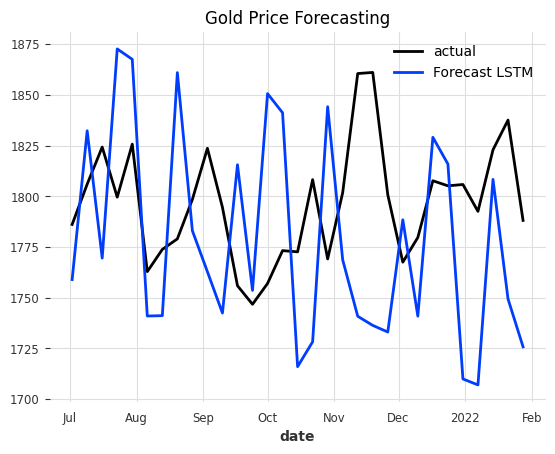

In [30]:
import matplotlib.pyplot as plt
# Plot the predictions and the real values
# series_transformed = scaler.inverse_transform(series)
# prediction_pandemic = scaler.inverse_transform(prediction_pandemic)
prediction = model.predict(n=31, past_covariates=covariates_scaled)
mape_lstm = mape(validate, prediction)
print('MAPE:', mape_lstm)
rev_validate = scaler.inverse_transform(validate)
rev_validate.plot(label='actual')
# series_usd.plot(label='actual')
rev_prediction_lstm = scaler.inverse_transform(prediction)
rev_prediction_lstm.plot(label='Forecast LSTM')
plt.title('Gold Price Forecasting')
plt.legend()

In [31]:
from darts.models import XGBModel

model_XGB = XGBModel(
    output_chunk_length=6,
    lags=14,
    lags_past_covariates=14,
    use_static_covariates=True,
    random_state = 42,   
)

# Train the model
model_XGB.fit(series=series, past_covariates=past_covariates, val_series=validate, val_past_covariates=future_covariates)

# Make predictions
prediction = model_XGB.predict(n=31, past_covariates=covariates_scaled)

# Evaluate the model
print('MAPE:', mape(validate, prediction))

[0]	validation_0-rmse:0.14581
[1]	validation_0-rmse:0.09881
[2]	validation_0-rmse:0.07603
[3]	validation_0-rmse:0.05610
[4]	validation_0-rmse:0.04555
[5]	validation_0-rmse:0.03924
[6]	validation_0-rmse:0.03424
[7]	validation_0-rmse:0.03082
[8]	validation_0-rmse:0.02802
[9]	validation_0-rmse:0.02524
[10]	validation_0-rmse:0.02444
[11]	validation_0-rmse:0.02375
[12]	validation_0-rmse:0.02306
[13]	validation_0-rmse:0.02227
[14]	validation_0-rmse:0.02221
[15]	validation_0-rmse:0.02211
[16]	validation_0-rmse:0.02194
[17]	validation_0-rmse:0.02193
[18]	validation_0-rmse:0.02179
[19]	validation_0-rmse:0.02176
[20]	validation_0-rmse:0.02173
[21]	validation_0-rmse:0.02169
[22]	validation_0-rmse:0.02190
[23]	validation_0-rmse:0.02189
[24]	validation_0-rmse:0.02189
[25]	validation_0-rmse:0.02187
[26]	validation_0-rmse:0.02187
[27]	validation_0-rmse:0.02185
[28]	validation_0-rmse:0.02186
[29]	validation_0-rmse:0.02186
[30]	validation_0-rmse:0.02166
[31]	validation_0-rmse:0.02167
[32]	validation_0-

/opt/conda/lib/python3.10/site-packages/sklearn/utils/deprecation.py:86: FutureWarning: Function delayed is deprecated; The function `delayed` has been moved from `sklearn.utils.fixes` to `sklearn.utils.parallel`. This import path will be removed in 1.5.
  warnings.warn(msg, category=FutureWarning)
/opt/conda/lib/python3.10/site-packages/sklearn/utils/parallel.py:114: UserWarning: `sklearn.utils.parallel.delayed` should be used with `sklearn.utils.parallel.Parallel` to make it possible to propagate the scikit-learn configuration of the current thread to the joblib workers.
  warnings.warn(


[80]	validation_0-rmse:0.02152
[81]	validation_0-rmse:0.02152
[82]	validation_0-rmse:0.02152
[83]	validation_0-rmse:0.02152
[84]	validation_0-rmse:0.02152
[85]	validation_0-rmse:0.02152
[86]	validation_0-rmse:0.02152
[87]	validation_0-rmse:0.02152
[88]	validation_0-rmse:0.02152
[89]	validation_0-rmse:0.02152
[90]	validation_0-rmse:0.02152
[91]	validation_0-rmse:0.02152
[92]	validation_0-rmse:0.02152
[93]	validation_0-rmse:0.02152
[94]	validation_0-rmse:0.02152
[95]	validation_0-rmse:0.02152
[96]	validation_0-rmse:0.02152
[97]	validation_0-rmse:0.02152
[98]	validation_0-rmse:0.02152
[99]	validation_0-rmse:0.02152
[0]	validation_0-rmse:0.14680
[1]	validation_0-rmse:0.10679
[2]	validation_0-rmse:0.08233
[3]	validation_0-rmse:0.06334
[4]	validation_0-rmse:0.05007
[5]	validation_0-rmse:0.04251
[6]	validation_0-rmse:0.03799
[7]	validation_0-rmse:0.03590
[8]	validation_0-rmse:0.03487
[9]	validation_0-rmse:0.03412
[10]	validation_0-rmse:0.03407
[11]	validation_0-rmse:0.03371
[12]	validation_0-

MAPE: 2.8229638934135437


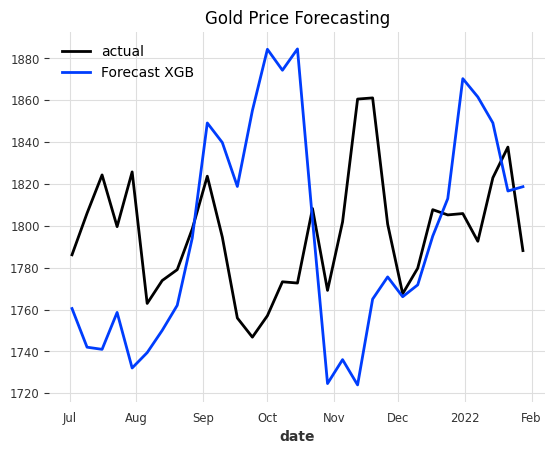

In [32]:
import matplotlib.pyplot as plt
# Plot the predictions and the real values
# series_transformed = scaler.inverse_transform(series)
# prediction_pandemic = scaler.inverse_transform(prediction_pandemic)
prediction = model_XGB.predict(n=31, past_covariates=covariates_scaled)
mape_xgb = mape(validate, prediction)
print('MAPE:', mape_xgb)
rev_validate= scaler.inverse_transform(validate)
rev_validate.plot(label='actual')
# series_usd.plot(label='actual')
rev_prediction_xgb = scaler.inverse_transform(prediction)
rev_prediction_xgb.plot(label='Forecast XGB')
plt.title('Gold Price Forecasting')
plt.legend()


In [15]:
from darts.models import TFTModel
from darts.utils.likelihood_models import QuantileRegression

# default quantiles for QuantileRegression
quantiles = [
    0.01,
    0.05,
    0.1,
    0.15,
    0.2,
    0.25,
    0.3,
    0.4,
    0.5,
    0.6,
    0.7,
    0.75,
    0.8,
    0.85,
    0.9,
    0.95,
    0.99,
]

input_chunk_length = 13
forecast_horizon = 11
model_TFT = TFTModel(
    input_chunk_length=13,
    output_chunk_length=11,
    hidden_size=34,
    lstm_layers=1,
    num_attention_heads=7,
    dropout=0.0918700540950769,
    batch_size=12,
    n_epochs=271,
    add_relative_index=True,
    add_encoders=None,
    likelihood=QuantileRegression(
        quantiles=quantiles
    ),  # QuantileRegression is set per default
    # loss_fn=MSELoss(),
    random_state=42,
)
# Train the model
model_TFT.fit(series=series, future_covariates=covariates_scaled)

# Make predictions
prediction = model_TFT.predict(n=31, future_covariates=covariates_scaled)

# Evaluate the model
print('MAPE:', mape(validate, prediction))

Training: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

MAPE: 2.9659047722816467


Predicting: |          | 0/? [00:00<?, ?it/s]

MAPE: 2.3089973255991936


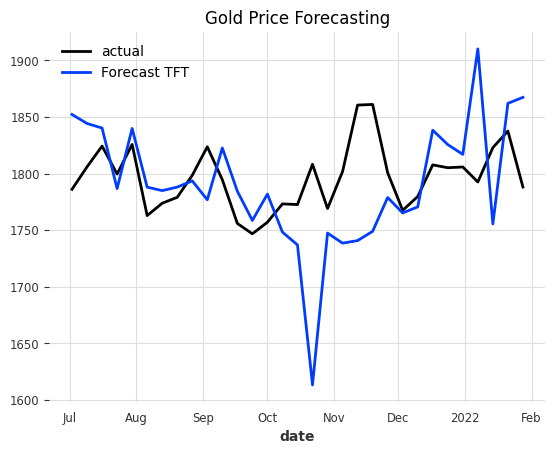

In [33]:
import matplotlib.pyplot as plt
# Plot the predictions and the real values
# series_transformed = scaler.inverse_transform(series)
# prediction_pandemic = scaler.inverse_transform(prediction_pandemic)
prediction = model_TFT.predict(n=31, future_covariates=covariates_scaled)
mape_tft = mape(validate, prediction)
print('MAPE:', mape_tft)
rev_validate = scaler.inverse_transform(validate)
rev_validate.plot(label='actual')
# series_usd.plot(label='actual')
rev_prediction_tft = scaler.inverse_transform(prediction)
rev_prediction_tft.plot(label='Forecast TFT')
plt.title('Gold Price Forecasting')
plt.legend()


In [17]:
model_TCN = TCNModel(
        weight_norm=True,
        log_tensorboard=True,
        force_reset=True,
        input_chunk_length=18,
        output_chunk_length=10, 
        n_epochs=131,
        dropout=0.11886015485421934,
        dilation_base=3,
        batch_size=58,
        kernel_size=7,
        num_filters=13,
        optimizer_kwargs={'lr': 4.5988647270933006e-05},
        num_layers=4,
        random_state=42)
# Train the model
model_TCN.fit(series=series, past_covariates=past_covariates, val_series=validate, val_past_covariates=future_covariates)

    # Make predictions
prediction = model_TCN.predict(n=31, past_covariates=covariates_scaled)

# Evaluate the model
print('MAPE:', mape(validate, prediction))


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/opt/conda/lib/python3.10/site-packages/pytorch_lightning/loops/fit_loop.py:293: The number of training batches (8) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

MAPE: 2.5984063744544983


Predicting: |          | 0/? [00:00<?, ?it/s]

MAPE: 2.5984063744544983


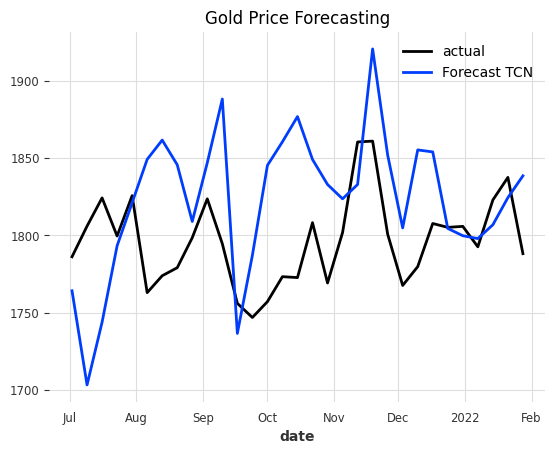

In [34]:
import matplotlib.pyplot as plt
# Plot the predictions and the real values
# series_transformed = scaler.inverse_transform(series)
# prediction_pandemic = scaler.inverse_transform(prediction_pandemic)
prediction = model_TCN.predict(n=31, past_covariates=covariates_scaled)
mape_tcn = mape(validate, prediction)
print('MAPE:', mape_tcn)
rev_validate = scaler.inverse_transform(validate)
rev_validate.plot(label='actual')
# series_usd.plot(label='actual')
rev_prediction_tcn = scaler.inverse_transform(prediction)
rev_prediction_tcn.plot(label='Forecast TCN')
plt.title('Gold Price Forecasting')
plt.legend()


# Results & Conclusions

As is evident from the results, we have used multiple methods to carry out multivariate timeseries forecasting and we have been able to reach less than 5% MAPE with each one which classify all these predictions as acceptably accurate. Thus we can accept the null hypothesis.

In [39]:
results = {'Long Short Term Memory':mape_lstm, 'Temporal Convolutional Network': mape_tcn, 'Temporal Fusion Transformer':mape_tft, 'XGBoost':mape_xgb}
df = pd.DataFrame.from_dict(results, orient='index', columns=["MAPE"])
df = df.reset_index().rename(columns={'index': 'Model'})
df

,Model,MAPE
0,Long Short Term Memory,3.06
1,Temporal Convolutional Network,2.60
2,Temporal Fusion Transformer,2.31
3,XGBoost,2.82


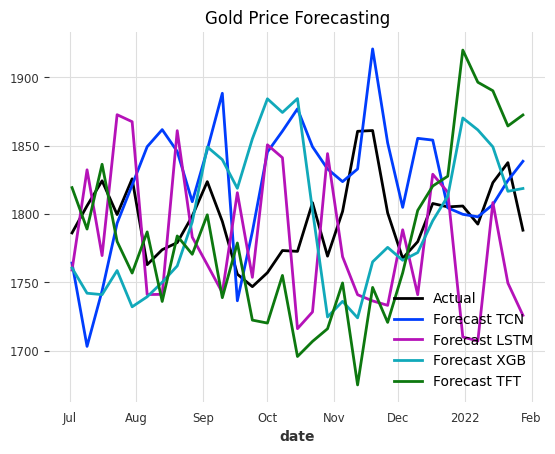

In [29]:
rev_validate = scaler.inverse_transform(validate)
rev_validate.plot(label='Actual')
rev_prediction_tcn.plot(label='Forecast TCN')
rev_prediction_lstm.plot(label='Forecast LSTM')
rev_prediction_xgb.plot(label='Forecast XGB')
rev_prediction_tft.plot(label='Forecast TFT')
plt.title('Gold Price Forecasting')
plt.legend()


In [19]:
# !pip install optuna

In [20]:
# import optuna
# from optuna.integration import PyTorchLightningPruningCallback
# from darts.models import TCNModel
# from darts.metrics import mape

# def objective(trial):
#     # Hyperparameters to optimize
#     input_chunk_length = trial.suggest_int("input_chunk_length", 13, 19)
#     output_chunk_length = trial.suggest_int("output_chunk_length", 8, 12)
#     num_layers = trial.suggest_int("num_layers", 2, 5)
#     num_filters = trial.suggest_int("num_filters", 10, 30)
#     kernel_size = trial.suggest_int("kernel_size", 3, 7)
#     dropout = trial.suggest_float("dropout", 0, 0.2)
#     lr = trial.suggest_float("lr", 1e-5, 1e-3, log=True)
#     batch_size = trial.suggest_int("batch_size", 8, 64)
#     dilation_base = trial.suggest_int("dilation_base", 2, 5)
#     n_epochs = trial.suggest_int("n_epochs", 100, 200)
    
#     model = TCNModel(
#         input_chunk_length=input_chunk_length,
#         output_chunk_length=output_chunk_length,
#         num_layers=num_layers,
#         num_filters=num_filters,
#         kernel_size=kernel_size,
#         dropout=dropout,
#         optimizer_kwargs={'lr': lr},
#         batch_size=batch_size,
#         dilation_base=dilation_base,
#         weight_norm=True,
#         log_tensorboard=True,
#         force_reset=True,
#         random_state=42,
#         n_epochs = n_epochs
#     )

#     # Train the model
#     model.fit(series=series, past_covariates=past_covariates, val_series=validate, val_past_covariates=future_covariates)

#     # Make predictions
#     prediction = model.predict(n=31, past_covariates=covariates_scaled)
#     error = mape(validate, prediction)

#     return error

# study = optuna.create_study(direction="minimize")
# study.optimize(objective, n_trials=100)

In [22]:
# import optuna
# from optuna.integration import PyTorchLightningPruningCallback
# from darts.models import BlockRNNModel
# from darts.metrics import mape

# def objective(trial):
#     # Hyperparameters to optimize
#     input_chunk_length = trial.suggest_int("input_chunk_length", 13, 19)
#     output_chunk_length = trial.suggest_int("output_chunk_length", 8, 12)
#     dropout = trial.suggest_float("dropout", 0, 0.2)
#     lr = trial.suggest_float("lr", 1e-5, 1e-3, log=True)
#     batch_size = trial.suggest_int("batch_size", 8, 64)
#     hidden_dim = trial.suggest_int("hidden_dim", 10, 50)
#     n_epochs = trial.suggest_int("n_epochs", 100, 300)
    
#     model = BlockRNNModel(
#     model='LSTM',
#     hidden_dim=hidden_dim,
#     dropout=dropout,
#     batch_size=batch_size,
#     n_epochs=n_epochs,
#     optimizer_kwargs={'lr': lr}, 
#     model_name='RNN_gold', 
#     log_tensorboard=True,
#     random_state=42,
#     input_chunk_length=input_chunk_length,
#     output_chunk_length=output_chunk_length,
#     force_reset=True
#     )

#     # Train the model
#     model.fit(series=series, past_covariates=past_covariates, val_series=validate, val_past_covariates=future_covariates)

#     # Make predictions
#     prediction = model.predict(n=31, past_covariates=covariates_scaled)
#     error = mape(validate, prediction)

#     return error

# study = optuna.create_study(direction="minimize")
# study.optimize(objective, n_trials=100)


In [23]:
# import optuna
# from optuna.integration import PyTorchLightningPruningCallback
# from darts.models import TFTModel
# from darts.metrics import mape
# from darts.utils.likelihood_models import QuantileRegression


# def objective(trial):
#     quantiles = [
#     0.01,
#     0.05,
#     0.1,
#     0.15,
#     0.2,
#     0.25,
#     0.3,
#     0.4,
#     0.5,
#     0.6,
#     0.7,
#     0.75,
#     0.8,
#     0.85,
#     0.9,
#     0.95,
#     0.99,
#     ]
    
#     # Hyperparameters to optimize
#     input_chunk_length = trial.suggest_int("input_chunk_length", 13, 19)
#     output_chunk_length = trial.suggest_int("output_chunk_length", 8, 12)
#     dropout = trial.suggest_float("dropout", 0, 0.2)
#     batch_size = trial.suggest_int("batch_size", 8, 64)
#     hidden_size = trial.suggest_int("hidden_size", 20, 80)
#     n_epochs = trial.suggest_int("n_epochs", 100, 300)
#     lstm_layers = trial.suggest_int("lstm_layers", 1, 10)
#     num_attention_heads = trial.suggest_int("num_attention_heads", 1, 10)
    
#     model_TFT = TFTModel(
#     input_chunk_length=input_chunk_length,
#     output_chunk_length=output_chunk_length,
#     hidden_size=hidden_size,
#     lstm_layers=lstm_layers,
#     num_attention_heads=num_attention_heads,
#     dropout=dropout,
#     batch_size=batch_size,
#     n_epochs=n_epochs,
#     add_relative_index=True,
#     add_encoders=None,
#     likelihood=QuantileRegression(
#         quantiles=quantiles
#     ),  # QuantileRegression is set per default
#     # loss_fn=MSELoss(),
#     random_state=42,
#     )
    
#     # Train the model
#     model_TFT.fit(series=series, future_covariates=covariates_scaled)

#     # Make predictions
#     prediction = model_TFT.predict(n=31, future_covariates=covariates_scaled)

#     error = mape(validate, prediction)

#     return error

# study = optuna.create_study(direction="minimize")
# study.optimize(objective, n_trials=100)
